# The Best Neighborhood in Pittsburgh: Halloween Trick-or-Treating
## This neighborhood... 
* has the best sense of community
* great for families and children
* will provide the highest volume/best quality candy
* is very walkable

# Datasets
1. Homeownership and Rental 2010-2014 Data
2. City of Pittsburgh Playgrounds
3. Sidewalk Street Ratio 2021/12/01 Blockgroup
4. Neighborhoods

### Submetric 1: Homeownership

Find the neighborhood with higher volume of property owners.  
1. Owning property is characteristic of settling down  
2. Majority of homeowners are 33+ (typical age of parents)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;a. important to eliminate neighborhoods with large amounts of college students
  
GOAL: Find the neighborhood with the best Halloween candy selection.

#### Import libraries and read in data

In [1]:
import pandas as pd
import numpy as np
homeownership = pd.read_csv("Homeownership.csv")
neighborhood = pd.read_csv("neighborhood.csv")

#### Check data types of dataframes

In [2]:
print("homeownership dftypes BEFORE\n",homeownership.dtypes)
print("\nneighborhood dtype BEFORE :", neighborhood['tractce10'].dtype)

homeownership dftypes BEFORE
 Census Tract       float64
TotalPopulation     object
OwnedMortgage       object
OwnedFree           object
RenterOccupied      object
dtype: object

neighborhood dtype BEFORE : object


#### -> Format homeownership data to be numeric

In [3]:
# fix types to be numeric
homeownership[['TotalPopulation','OwnedMortgage','OwnedFree','RenterOccupied']]\
= homeownership.apply(lambda x: x[['TotalPopulation','OwnedMortgage','OwnedFree','RenterOccupied']].str.replace(',','').astype(float), axis=1)

#### -> Format neighborhood data to be numeric

In [4]:
# utilize Pandas Series to convert all elements into one datatype
census_tract = pd.Series(neighborhood.iloc[:,4]) # index 4 is tractce10 column

for i in range(len(census_tract)):
    string = census_tract[i]
    # if not empty string
    if (string != ''):
        firstChar = string[0]
        try:
            float(firstChar)
            # if the firstChar is a number that starts with 0 as a placeholder (e.g., 024500)
            if (firstChar == '0' and len(string) > 1):
                # remove the first character
                string = string[1:]
            # remove extra zeros at the end
            census_tract[i] = string[0:len(string)-2]
            
        # first char cannot be converted to a float
        except ValueError:
            census_tract[i] = 0
    
    # if empty string
    else:
        census_tract[i] = 0
# end of for loop

# create dataframe and cast elements to float
census_tracts_mapping = pd.DataFrame(census_tract).astype(float, errors = 'raise')

#### Check data types (again)

In [5]:
print("homeownership dftypes AFTER\n",homeownership.dtypes)
print("\ndtype neighborhood dtype AFTER:", census_tracts_mapping['tractce10'].dtypes)

homeownership dftypes AFTER
 Census Tract       float64
TotalPopulation    float64
OwnedMortgage      float64
OwnedFree          float64
RenterOccupied     float64
dtype: object

dtype neighborhood dtype AFTER: float64


#### Find total number of homeowners (payed mortgage + making payments at time of census)

In [6]:
# sum OwnedMortgage and OwnedFree columns
homeowners = homeownership['OwnedMortgage'] + homeownership['OwnedFree']

#### Calculate ratio of homeowners to renters in each census tract

In [7]:
# find ratio of homeowners to renters
ratioSettled2Renting = homeowners/homeownership['RenterOccupied']

#### Create a new dataframe

In [8]:
# create new dataframe
ratio = pd.DataFrame(ratioSettled2Renting, columns=["Settled/renting"])
census_tracts = pd.DataFrame(homeownership['Census Tract'])
population = pd.DataFrame(homeownership['TotalPopulation'])
my_df = census_tracts.join(ratio).join(population)

# SORT & FILTER
my_dfsorted = my_df.sort_values(by=['Settled/renting'], ascending=False)
my_dfFiltered = my_dfsorted[my_dfsorted['TotalPopulation'] >= 500]

my_dfFiltered.head(10)

,Census Tract,Settled/renting,TotalPopulation
152,4268.00,43.741667,5369.0
244,4753.03,33.151261,4064.0
384,5641.00,32.923077,882.0
122,4100.00,30.648649,1171.0
237,4742.01,28.545455,2600.0
239,4742.03,27.306250,4529.0
125,4120.02,26.331461,4865.0
318,5190.00,23.680328,3011.0
149,4263.00,22.647059,6030.0
130,4134.00,21.978610,4297.0


#### Map census tract to neighborhood via neighborhood.csv
##### Filter out Allegheny census tracts that are not City of Pittsburgh census tracts.

In [9]:
# list of 90 census tracts mapped to city of Pittsburgh neighborhood
city_of_pgh_cetracts = census_tracts_mapping['tractce10']
# list of census tracts included in the homeowners dataset for allegheny county
allegheny_cetracts = my_dfFiltered['Census Tract']
# create a dictionary of city of pgh census tract -> city of pgh neighborhood
neighborhood.rename(columns = {"hood":"Neighborhood"}, inplace = True)
dict = {'census tract': city_of_pgh_cetracts, 'pgh neighborhood': neighborhood["Neighborhood"]}
dict = pd.DataFrame(dict)

best_tracts_pgh = [0]*len(allegheny_cetracts)
best_nbhds= []
best_match = 6000
limit = 5 # ensure we find the closest census tracts to represent the neighborhood 
cnt = 0
# loop through allegheny census tracts
for i in allegheny_cetracts:
    best_match = 6000
    # loop through all 90 pgh cetracts
    for j in city_of_pgh_cetracts:
        best_tracts_pgh[cnt] = 0
        diff = i - j
        # if diff is 0 then we found the neighborhood
        if diff == 0:
            # add i to best_tracts_pgh
            best_tracts_pgh[cnt] = j
            break 
        elif abs(diff) < best_match and abs(diff) < limit:
            best_match = diff
            best_tracts_pgh[cnt] = j
    cnt = cnt + 1

#### Retrieve the top ten neighborhoods

In [10]:
for w in best_tracts_pgh:
    index = 0
    if (w!=0):
        for p in dict['census tract']:
            if (w==p):
                best_nbhds.append(dict['pgh neighborhood'][index])
                break
            index = index + 1
                
best_nbhds_homeownership = pd.DataFrame(best_nbhds)
best_nbhds_homeownership.columns = ['Neighborhood']
best_nbhds_homeownership.head(10)     

,Neighborhood
0,New Homestead
1,Stanton Heights
2,Lincoln Place
3,Swisshelm Park
4,Overbrook
5,Summer Hill
6,Regent Square
7,Brookline
8,Squirrel Hill North
9,Brighton Heights


### Submetric 2:

description：In my part, I analyzed the number of playgrounds in Pittsburgh differnt neighborhood


In [11]:
#Imports
import pandas as pd
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt

#### First, read the original csv file using pandas.（

In [12]:
playground = pd.read_csv("Playground.csv")
# playground
playground["neighborhood"]

0                Beechview
1         Crawford-Roberts
2        Central Northside
3                Beechview
4        Bedford Dwellings
              ...         
120                Carrick
121    Upper Lawrenceville
122            Beltzhoover
123           East Liberty
124         East Allegheny
Name: neighborhood, Length: 125, dtype: object

#### Then I created a dictionary myDictionary to store only neighborhood coloumn in the generated playground series, and add its number if they are in the same neighborhood

In [14]:
myDictionary = {}
for i in range(len(playground)):
    temp = playground.loc[i,"neighborhood"]
    if(temp not in myDictionary):
       myDictionary[temp] = 1
    else:
       myDictionary[temp] += 1
       
# print(myDictionary)
myDictionary

{'Beechview': 5,
 'Crawford-Roberts': 3,
 'Central Northside': 2,
 'Bedford Dwellings': 1,
 'South Side Slopes': 5,
 'South Side Flats': 2,
 'Lower Lawrenceville': 1,
 'Banksville': 1,
 'Homewood North': 1,
 'Bon Air': 1,
 'Central Oakland': 1,
 'Brighton Heights': 2,
 'Brookline': 2,
 'Hazelwood': 3,
 'Squirrel Hill South': 8,
 'Spring Garden': 1,
 'Lincoln-Lemington-Belmar': 2,
 'Windgap': 1,
 'Troy Hill': 2,
 'Westwood': 1,
 'Perry South': 1,
 'Homewood West': 1,
 'Allegheny Center': 4,
 'Strip District': 1,
 'Stanton Heights': 1,
 'Crafton Heights': 2,
 'West Oakland': 1,
 'East Carnegie': 1,
 'Duquesne Heights': 1,
 'East Liberty': 3,
 'Esplen': 1,
 'Fairywood': 1,
 'Highland Park': 4,
 'Upper Lawrenceville': 3,
 'Fineview': 1,
 'Regent Square': 1,
 'Garfield': 2,
 'Greenfield': 2,
 'South Oakland': 3,
 'Allentown': 1,
 'Hays': 1,
 'Elliott': 3,
 'Morningside': 2,
 'Terrace Village': 1,
 'Larimer': 1,
 'Carrick': 3,
 'Central Lawrenceville': 1,
 'Lincoln Place': 2,
 'Manchester': 

#### But it is easier for me to plot a graph with Series rather than dictionary. So here I converted this dictionary back to Series.



In [15]:
playGroundSeries = pd.Series(myDictionary, name = "Fields")
playGroundSeries

Beechview              5
Crawford-Roberts       3
Central Northside      2
Bedford Dwellings      1
South Side Slopes      5
                      ..
West End               1
Polish Hill            1
Point Breeze North     1
Squirrel Hill North    1
East Allegheny         1
Name: Fields, Length: 68, dtype: int64

#### And since the dataframe is too much, and many of them(neighborhood) only has 1 playground(duplicates). And since we only need the largest number of data, so I decided take the "top30" number of playground in Pittsburgh. and display them

In [16]:
# First sort this series with descending order(Ascending = False)
SeriesInDescendingOrder=playGroundSeries.sort_values(ascending=False)
SeriesInDescendingOrder.head(30)
SeriesInDescendingOrder = pd.DataFrame(SeriesInDescendingOrder)
SeriesInDescendingOrder

,Fields
Squirrel Hill South,8
Beechview,5
South Side Slopes,5
Highland Park,4
Sheraden,4
...,...
Esplen,1
Fairywood,1
Regent Square,1
Allentown,1


#### display our sorted dataframe by bar graph

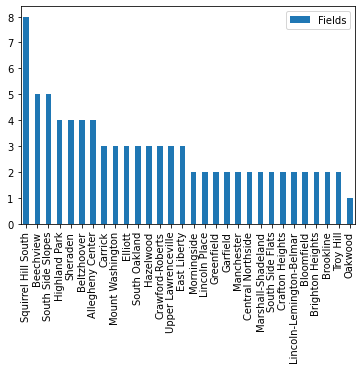

In [17]:
SeriesInDescendingOrder.head(30).plot.bar()

### From this graph we can easily see the Squirrel Hill South has the most playgrounds, 8 playgrounds, in Pittsburgh area. And Beechview, South Side Slopes fllow as the second most

### Submetric 3: Walk Ratio

Find the neighborhood with the highest walk ratio(Walkability)  
1. The more walk ratio means that neighborhood more likely a good place to walk.
2. With more walk ratio(Walkability), parents are more likely to allow their kids to walk on streets and ask for candies.

The dataset: Sidewalk Street Ratio 2021/12/01 Blockgroup

#### Read the csv file(GEOID and Ratio), pull out the two columns(fields) that I need, and get rid of NaN(invalid) values.

In [18]:
sideWalk = pd.read_csv("Sidewalk Ratio.csv")


sideWalk = sideWalk.loc[:, ['GEOID', 'Ratio']] #.unique()
# make a mask to delete NaN Ratio neighborhood
sideWalk_mask = sideWalk['Ratio'] >= 0
sideWalk = sideWalk[sideWalk_mask]

sideWalk['GEOID'] = sideWalk['GEOID'].apply(np.int64)
# .astype({'GEOID':'int'})   this didn't work :(  because our GEOID is out of the maximum of Int type

print(sideWalk.dtypes) # Casting successed
sideWalk

GEOID      int64
Ratio    float64
dtype: object


,GEOID,Ratio
0,420030103001,0.441776
1,420030103002,1.551697
2,420030103003,1.538866
3,420030103004,1.249711
4,420030201001,1.799394
...,...,...
1095,420039810001,1.623941
1096,420039811001,1.766703
1097,420039812001,3.179914
1098,420039818001,1.618777


#### Read the csv file(GEOID and Hood names), this step is similar to previous step

In [19]:
neighborhoodName = pd.read_csv("neighborhood.csv")
neighborhoodName = neighborhoodName.loc[:, ['geoid10', 'hood']]  # we only need our GEOID and hood(the actual name relates to the GEOID)
neighborhoodName.rename(columns = {'geoid10':'GEOID'}, inplace = True) # doing a rename process, so that these two dataframe can be merged later

neighborhoodName['GEOID'].str.replace(' ','')   # there is some weird space in GEOID, so I deleted them.
neighborhoodName = neighborhoodName.drop(15)  # the fifteenth rows in the original dataframe is wrong, so I dropped it manually 
neighborhoodName['GEOID'] = neighborhoodName['GEOID'].apply(np.int64)   # cast the GEOID, which originally is a str type, into int type
# so that we can merge them together rather than geting some errors
# .astype({'GEOID':'int'})   this didn't work :(  because our GEOID is out of the maximum of Int type
print(neighborhoodName.dtypes)
neighborhoodName.head(5)

GEOID     int64
hood     object
dtype: object


,GEOID,hood
0,420031405003,Point Breeze North
1,420031401003,Squirrel Hill North
2,420031017002,Garfield
3,420030509001,Bedford Dwellings
4,420033001005,Knoxville


#### Now is the time to merge this two: (GEOID, Ratio) & (GEOID, Hood names) -> (Hood Names, Ratio)

In [20]:
# theRightDataFrame = pd.concat([sideWalk,neighborhood], axis=0)  # this method just brutally squeeze the two dfs into one(Not what I want)
theRightDataFrame = pd.merge(sideWalk,neighborhoodName, on="GEOID")  # this method is what we want
pd.options.display.max_rows = 100   # so that we can see more rows 
theRightDataFrame=theRightDataFrame.sort_values(by=['Ratio'],ascending=False) # sort our correct df with a decesning order by "Ratio"
# theRightDataFrame.dropna()
theRightDataFrame.drop('GEOID', axis=1, inplace= True)   # delete the not that meaningful GEOID column
theRightDataFrame = theRightDataFrame[['hood','Ratio']]  # Change the columns display order(I like it this way), swap these two column
display(theRightDataFrame)    # display my dataframe

,hood,Ratio
10,Bedford Dwellings,6.644908
28,Squirrel Hill North,3.615286
71,Allegheny Center,3.227465
83,Lincoln-Lemington-Belmar,3.092941
11,Terrace Village,3.017543
49,Northview Heights,2.712593
25,Homewood North,2.512087
19,Garfield,2.322960
29,Point Breeze North,2.319320
15,Bloomfield,2.265926


#### After we get the dataframe, we can plot it into a bar chart

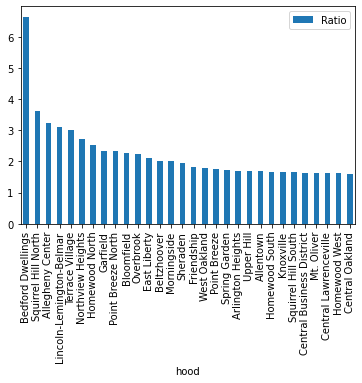

In [21]:
# theRightDataFrame = theRightDataFrame.head(30)
theRightDataFrame.head(30).plot.bar(x= 'hood')

### Combining submetrics

***Homeownership:***  
* 5 points for top 5 neighborhoods
* 4 points for the following 10 nbhds
* 3 for next 15
* 2 for next 20
* 1 point for the rest
  
***Playground:***    
* 3 points for neighborhoods with greater than or equal to 3 playgrounds
* 2 points for nbhds with 2 playgrounds
* 1 points for nbhds with 1 playground
  
***Walkability:***   
* 3 points for top 10 neighborhoods
* 2 points for the next 20
* 1 points for the rest

In [22]:
## set up the final dataframe
zeros = np.zeros(len(neighborhood), dtype = int)
nbhds = neighborhood.loc[:,"Neighborhood"]
# Create a Series from those two lists
final_nbhds = pd.Series(zeros, index=nbhds)

## Add points according to homeownership analysis
add_points = best_nbhds_homeownership["Neighborhood"][0:10]
final_nbhds.loc[add_points] += 2
add_points = best_nbhds_homeownership["Neighborhood"][0:15]
final_nbhds.loc[add_points] += 1
add_points = best_nbhds_homeownership["Neighborhood"][0:30]
final_nbhds.loc[add_points] += 1
add_points = best_nbhds_homeownership["Neighborhood"][0:50]
final_nbhds.loc[add_points] += 1
add_points = best_nbhds_homeownership["Neighborhood"][0:90]
final_nbhds.loc[add_points] += 1

In [23]:
## Same thing..
## Add results from playground dataset
# set up previous analysis into a format appropriate for merging results
best_nbhds_playground = pd.DataFrame(SeriesInDescendingOrder.index)
best_nbhds_playground.rename(columns = {0:"Neighborhood"}, inplace = True)
# add points
add_points = best_nbhds_playground["Neighborhood"][30:68]
final_nbhds.loc[add_points] += 1
add_points = best_nbhds_playground["Neighborhood"][16:29]
final_nbhds.loc[add_points] += 2
add_points = best_nbhds_playground["Neighborhood"][0:15]
final_nbhds.loc[add_points] += 3

In [24]:
## Same thing..
## Add results from walkability dataset
# format
best_nbhds_walkability = pd.DataFrame(theRightDataFrame["hood"])
best_nbhds_walkability.rename(columns = {"hood":"Neighborhood"}, inplace = True)
# add points
add_points = best_nbhds_walkability["Neighborhood"][0:4]
final_nbhds.loc[add_points] += 5
add_points = best_nbhds_walkability["Neighborhood"][5:9]
final_nbhds.loc[add_points] += 4
add_points = best_nbhds_walkability["Neighborhood"][10:19]
final_nbhds.loc[add_points] += 3
add_points = best_nbhds_walkability["Neighborhood"][20:39]
final_nbhds.loc[add_points] += 2
add_points = best_nbhds_walkability["Neighborhood"][40:89]
final_nbhds.loc[add_points] += 1

In [25]:
## Make the final dataframe and see who wins!
best_pgh_nbhds = pd.DataFrame(final_nbhds)
best_pgh_nbhds.rename(columns = {0:'Points'}, inplace = True)
best_pgh_nbhds = best_pgh_nbhds.sort_values(by=["Points"], ascending=False)
best_pgh_nbhds.head(30)

,Points
Neighborhood,
Squirrel Hill North,12
Beltzhoover,10
Lincoln Place,9
Stanton Heights,9
Brighton Heights,9
Brookline,9
Sheraden,9
Overbrook,9
Squirrel Hill South,8


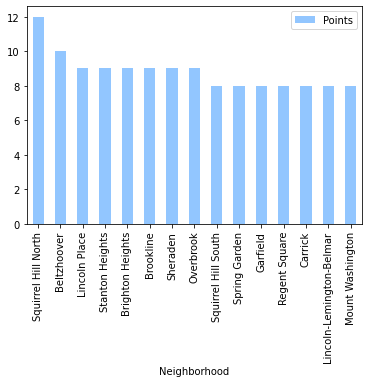

In [36]:
plt.style.use('seaborn-pastel')
best_pgh_nbhds.head(15).plot.bar()

# The Winner is Squirrel Hill North!!!

### Conclusion

response 1 Isabel Gonzalez: I really like Squirrel Hill North and it seems like a great place to bring kids for trick-or-treating. The houses are really nice, and the neighborhood is very walkable, so I am not surprised that it won!

response 2 Jeffery Wang: My conclusion to this project is the winner is squirrel hill, from the data we found and the final graph we analyze, squirrel hill occupies the most proportion. Besides, I learned how to use panda properly and how to select data correctly, also using google helps me to understand every step and the meaning of doing every code cell. At last, I want to thank my teammate sincerely, they really help me a lot and teach me patiently, this project is a meaningful journey for me.

response 3 (name): Haoshen Wu